In [2]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

# 创建回测引擎
engine = BacktestingEngine()
engine.setDB_URI("mongodb://localhost:27017")

# 设置回测模式
engine.setBacktestingMode(engine.BAR_MODE)
engine.setDatabase('VnTrader_1Min_Db')

# 设置回测日期，initHours 默认值为 0
engine.setStartDate('20180201 23:00:00',initHours=10)   
engine.setEndDate('20190320 23:00:00')

# 设置品种，手续费，滑点
engine.setCapital(10000000)  # 设置起始资金，默认值是1,000,000
contracts = [{
                "symbol":"IF88:CTP",
                "size" : 1, # 每点价值
                "priceTick" : 0.1, # 最小价格变动
                "rate" : 5/10000, # 单边手续费
                "slippage" : 0.1 # 滑价
                },] 

engine.setContracts(contracts)
settingList = [{
                "symbolList": ["IF88:CTP"]
                }]   

# 策略
1. long: macd[-1]>0 and macd[-2]<0 and macd[-1]>macd[-3] and macdSignal[-1]>macdSignal[-3]

2. short: macd[-1]<0 and macd[-2]>0 and macd[-1]<macd[-3] and macdSignal[-1]<macdSignal[-3]

In [3]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
from datetime import datetime

In [4]:
########################################################################
# 策略继承CtaTemplate
class MacdStrategy(CtaTemplate):
    className = 'MaStrategy'
    author = 'Cyan'
    symbolList = ["IF88:CTP"]
    
    # 策略参数
    fastPeriod = 12     # 快速均线参数
    slowPeriod = 26    # 慢速均线参数
    signalPeriod = 9
    lot = 1             # 设置手数
    
    # 策略变量
    transactionPrice = None # 记录成交价格
    
    
    # 参数列表
    paramList = [
                 'fastPeriod',
                 'slowPeriod'
                 'signalPeriod'
                ]    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.chartLog = {
                        'datetime':[],
#                         'fastMa':[],
#                         'slowMa':[]
                        'macd':[],
                        'macdsignal':[],
                        'macdhist':[]
                        }
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """30分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am30 = self.getArrayManager(symbol, "30m") # 获取历史数组
        
        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
#         fastMa = ta.EMA(am30.close, self.fastPeriod)
#         slowMa = ta.EMA(am30.close, self.slowPeriod)
#         macd = ta.MACD(am30.close, self.fastPeriod, self.slowPeriod, duringPeriod)
        macd, macdsignal, macdhist = ta.MACD(am30.close, self.fastPeriod, self.slowPeriod, self.signalPeriod)
        
        self.chartLog['datetime'].append(datetime.strptime(am30.datetime[-1], "%Y%m%d %H:%M:%S"))
        self.chartLog['macd'].append(macd[-1])
        self.chartLog['macdsignal'].append(macdsignal[-1])
        self.chartLog['macdhist'].append(macdhist[-1])
#         self.chartLog['slowMa'].append(slowMa[-1])
        
        crossOver = (macd[-1]>0 and macd[-2]<0) and (macd[-1]>macd[-3]) and (macdsignal[-1]>macdsignal[-3]) # 金叉上穿 
        crossBelow = (macd[-1]<0 and macd[-2]>0) and (macd[-1]<macd[-3]) and (macdsignal[-1]<macdsignal[-3]) # 死叉下穿

        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果死叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [5]:
from vnpy.trader.utils import htmlplot
engine.setLog(True, "./log")
engine.initStrategy(MacdStrategy, settingList[0])
# 开始跑回测
engine.runBacktesting()

F:\anaconda\lib\site-packages\vnpy\trader\utils\htmlplot\core.py:8: UserWarning: Expected version of bokeh is 0.12.14, current version is 1.0.4
  warnings.warn("Expected version of bokeh is 0.12.14, current version is %s" % bokeh.__version__)


初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-05-22 10:31:31.142005	开始回测
2019-05-22 10:31:31.142005	策略初始化
2019-05-22 10:31:31.144989	准备载入数据：时间段:[20180201 13:00:00 , 20180201 23:00:00), 模式: bar
2019-05-22 10:31:31.556888	IF88:CTP： 从本地缓存文件实取120, 最大应取600, 还需从数据库取480
2019-05-22 10:31:31.628697	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-22 10:31:31.629731	载入完成, 数据量:120
2019-05-22 10:31:31.629731	初始化预加载数据成功, 数据长度:120
2019-05-22 10:31:31.629731	策略初始化完成
2019-05-22 10:31:31.629731	策略启动完成
2019-05-22 10:31:31.629731	回测时间范围:[20180201 23:00:00,20190320 23:00:00)
2019-05-22 10:31:31.629731	当前回放的时间段:[20180201 23:00:00,20190320 23:00:00)
2019-05-22 10:31:34.689519	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-05-22 10:31:40.651589	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-05-22 10:31:43.119028	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-22 10:31:43.138953	载入完成, 数据量:65040
2019-05-22 10:31:43.209755	准备载入数据：时间段:[20180201 07:51:00 , 20180203 23:01:00), 模式: bar
2019-05-22 10:31:43.254640	

2019-05-22 10:31:48.791842	计算回测结果
2019-05-22 10:31:48.805804	交割单已生成
2019-05-22 10:31:48.806841	------------------------------
2019-05-22 10:31:48.806841	第一笔交易：	2018-02-28 13:00:00
2019-05-22 10:31:48.806841	最后一笔交易：	2019-03-20 14:58:00
2019-05-22 10:31:48.806841	总交易次数：	49
2019-05-22 10:31:48.806841	总盈亏：	97.69
2019-05-22 10:31:48.806841	最大回撤: 	-621.63
2019-05-22 10:31:48.806841	平均每笔盈利：	1.99
2019-05-22 10:31:48.806841	平均每笔滑点：	0.2
2019-05-22 10:31:48.806841	平均每笔佣金：	3.52
2019-05-22 10:31:48.806841	胜率		36.73%
2019-05-22 10:31:48.806841	盈利交易平均值	107.44
2019-05-22 10:31:48.806841	亏损交易平均值	-59.23
2019-05-22 10:31:48.806841	盈亏比：	1.81
2019-05-22 10:31:49.092071	策略回测统计图已保存


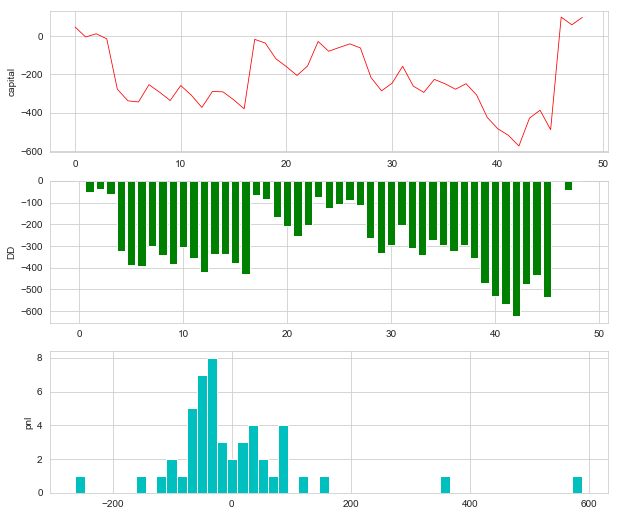

In [6]:
# 显示回测的每张订单绩效
engine.showBacktestingResult()

2019-05-22 10:31:49.461053	计算按日统计结果
2019-05-22 10:31:49.504934	------------------------------
2019-05-22 10:31:49.504934	首个交易日：	2018-02-02
2019-05-22 10:31:49.504934	最后交易日：	2019-03-20
2019-05-22 10:31:49.504934	总交易日：	271
2019-05-22 10:31:49.505932	盈利交易日	136
2019-05-22 10:31:49.505932	亏损交易日：	127
2019-05-22 10:31:49.505932	起始资金：	10000000
2019-05-22 10:31:49.505932	结束资金：	10,000,099.71
2019-05-22 10:31:49.505932	总收益率：	0.0%
2019-05-22 10:31:49.505932	年化收益：	0.0%
2019-05-22 10:31:49.505932	总盈亏：	99.71
2019-05-22 10:31:49.505932	最大回撤: 	-734.84
2019-05-22 10:31:49.505932	百分比最大回撤: -0.01%
2019-05-22 10:31:49.505932	总手续费：	170.39
2019-05-22 10:31:49.505932	总滑点：	9.7
2019-05-22 10:31:49.505932	总成交金额：	340,782.2
2019-05-22 10:31:49.505932	总成交笔数：	97
2019-05-22 10:31:49.505932	日均盈亏：	0.37
2019-05-22 10:31:49.505932	日均手续费：	0.63
2019-05-22 10:31:49.505932	日均滑点：	0.04
2019-05-22 10:31:49.505932	日均成交金额：	1,257.5
2019-05-22 10:31:49.505932	日均成交笔数：	0.36
2019-05-22 10:31:49.505932	日均收益率：	0.0%
2019-05-22 10:31:49.50

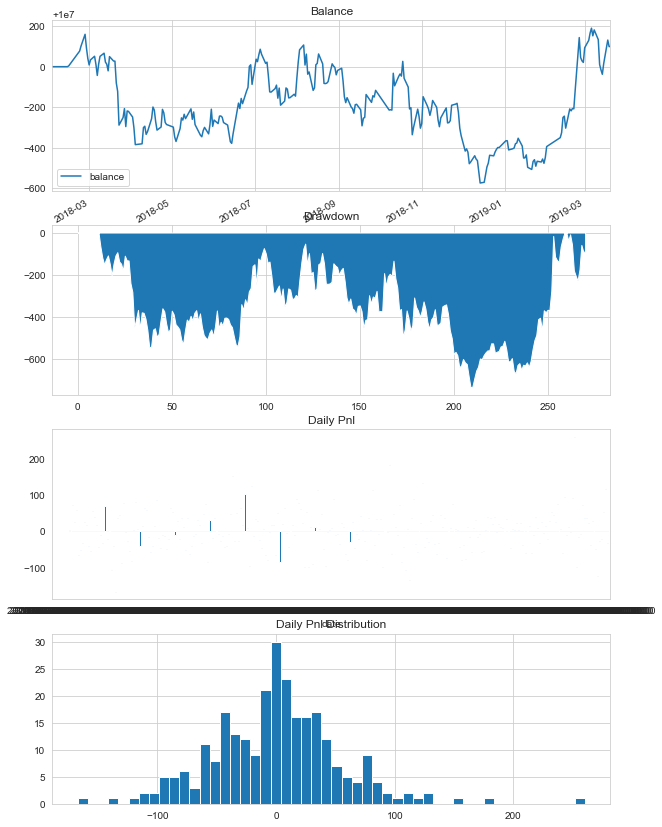

In [7]:
# 显示回测的每日绩效
engine.showDailyResult()

In [8]:
### 画图分析
chartLog = pd.DataFrame(engine.strategy.chartLog).set_index('datetime')
mp = htmlplot.getMultiPlot(engine, freq="30m")
mp.set_line(line=chartLog[['macd', 'macdsignal','macdhist']], colors={'macd': 'red','macdsignal':'blue','macdhist':'green'}, pos=0)
mp.show()

# 优化

In [9]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
engine.setLog(False)
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('fastPeriod', 10, 40, 30)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod', 30, 60, 30)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('signalPeriod', 20, 50, 30)
setting.addParameter('symbolList', ['IF88:CTP']) 

In [11]:
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(MacdStrategy, setting)

print('耗时：%s' %(time.time()-start))

2019-05-22 10:32:32.086164	------------------------------
2019-05-22 10:32:32.087163	setting: {'fastPeriod': 10, 'slowPeriod': 30, 'signalPeriod': 20, 'symbolList': ['IF88:CTP']}
初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-05-22 10:32:32.089191	开始回测
2019-05-22 10:32:32.089191	策略初始化
2019-05-22 10:32:32.092182	准备载入数据：时间段:[20180201 13:00:00 , 20180201 23:00:00), 模式: bar
2019-05-22 10:32:32.117082	IF88:CTP： 从本地缓存文件实取120, 最大应取600, 还需从数据库取480
2019-05-22 10:32:32.137030	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-22 10:32:32.138026	载入完成, 数据量:120
2019-05-22 10:32:32.138026	初始化预加载数据成功, 数据长度:120
2019-05-22 10:32:32.139024	策略初始化完成
2019-05-22 10:32:32.139024	策略启动完成
2019-05-22 10:32:32.139024	回测时间范围:[20180201 23:00:00,20190320 23:00:00)
2019-05-22 10:32:32.140047	当前回放的时间段:[20180201 23:00:00,20190320 23:00:00)
2019-05-22 10:32:35.201840	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-05-22 10:32:41.392302	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-05-22 10:32:43.918552	IF

In [12]:
print(pd.DataFrame(resultList).sort_values(1,  ascending=False))

                                                   0         1  \
0  {'fastPeriod': 10, 'slowPeriod': 30, 'signalPe...  0.299744   
1  {'fastPeriod': 10, 'slowPeriod': 30, 'signalPe...  0.299744   
2  {'fastPeriod': 10, 'slowPeriod': 60, 'signalPe...  0.299744   
3  {'fastPeriod': 10, 'slowPeriod': 60, 'signalPe...  0.299744   
4  {'fastPeriod': 40, 'slowPeriod': 30, 'signalPe... -0.656377   
5  {'fastPeriod': 40, 'slowPeriod': 30, 'signalPe... -0.656377   
6  {'fastPeriod': 40, 'slowPeriod': 60, 'signalPe... -0.656377   
7  {'fastPeriod': 40, 'slowPeriod': 60, 'signalPe... -0.656377   

                                                   2  
0  {'startDate': '2018-02-02', 'endDate': '2019-0...  
1  {'startDate': '2018-02-02', 'endDate': '2019-0...  
2  {'startDate': '2018-02-02', 'endDate': '2019-0...  
3  {'startDate': '2018-02-02', 'endDate': '2019-0...  
4  {'startDate': '2018-02-02', 'endDate': '2019-0...  
5  {'startDate': '2018-02-02', 'endDate': '2019-0...  
6  {'startDate': '20

# 科学研究策略的流程——择时策略

## 获取数据
### **清洗数据**
## 画图看数据是否缺失
## 信号研究
### 信号

* 买入：RSI小于30买入

* 卖出：RSI大于85卖出

* 其他情况持仓不动

### 编写信号

* 读取数据，计算RSI

* 可视化指标

* 编写信号，若RSI小于30则看多，siganl为1，RSI大于85则看空，signal为-1，若在中间，则为0

### 可视化数据与信号
## 思路验证
### 验证策略可行性

* 通过VNPY回测策略思路得到回测绩效
### 优化参数
### 发现问题并提出解决方案